<div style="background-color:purple; color:white; padding:10px;">
    <h1><a name="TABLEOFCONTENTS"></a>TABLE OF CONTENTS</h1>
</div>


1. [INTRODUCTION](#INTRODUCTION)
2. [DATA PREPARATION](#DATA_PREPARATION)
3. [CLUSTERING USING ABSOLUTE CORRELATION](#CLUSTERING_USING_ABSOLUTE_CORRELATION)
4. [SUB-CLUSTER LABELING](#SUB-CLUSTER_LABELING)
5. [VALIDATION](#VALIDATION)
     - [ABSOLUTE CLUSTERS](#ABSOLUTE_CLUSTERS)
     - [THE FINAL CLUSTERS](#THE_FINAL_CLUSTERS)
     - [INTER-CLUSTER CORRELATIONS](#INTER-CLUSTER_CORRELATION)
6. [CONCLUSION](#CONCLUSION)

<div style="background-color:purple; color:white; padding:10px;">
    <h1><a name="INTRODUCTION"></a>INTRODUCTION</h1>
</div>

This notebook delves into exploring correlations among various stocks within the Optiver Trading at the Close competition. In this competition, a total of 200 stocks are provided without any sector labels. We can anticipate significant correlations among certain stocks, particularly if they belong to the same sector. Conversely, it is plausible that an increase in one stock's value may exert an influence on the decrease of another stock.

A convenient approach to extract insights from this behavior is to leverage correlation data among the stocks. In this notebook, I construct a correlation matrix to depict the relationships among these stocks. Initially, I compute the absolute values of these correlation coefficients and perform clustering, yielding a total of 13 distinct clusters. Subsequently, I apply another level of clustering within each cluster to segregate stocks with both positive and negative correlations. The clusters are denoted in the "Combined_Label" feature in a number_letter(for example 1_a) format. Consequently, you can anticipate that stocks within, for instance, the 4_a cluster exhibit high positive correlations among themselves, while being negatively correlated with the stocks in the 4_b cluster.

Lastly, I have incorporated a validation section to assess correlation values within and between the clusters.

I have drawn inspiration from the code available [Optiver|ExtensiveEDA, R. RAMAKRISHNAN](https://www.kaggle.com/code/ravi20076/optiver-extensiveeda), which primarily focuses on stock performance analysis. The stock performance plots included in this notebook already offer clear indications of strong correlations among certain stocks. Additionally, I have utilized data from [Optiver-MemoryReducedDatasets, R. RAMAKRISHNAN](https://www.kaggle.com/datasets/ravi20076/optiver-memoryreduceddatasets) as the data source.

If you find this notebook valuable or informative, please consider upvoting it. This is a continuous learning journey for me, and I welcome any comments or suggestions you may have.

<div style="background-color:purple; color:white; padding:10px;">
    <h1><a name="DATA_PREPARATION"></a>DATA PREPARATION</h1>
</div>

Below, essential import statements are incorporated to set the stage for our analysis. The resulting data structure, named 'stock_performance,' is modeled after the one used in [Optiver|ExtensiveEDA, R. RAMAKRISHNAN](https://www.kaggle.com/code/ravi20076/optiver-extensiveeda). This DataFrame employs a targeted feature described as "The 60 second future move in the wap of the stock, less the 60 second future move of the synthetic index. Only provided for the train set." a parameter explicitly detailed in the competition's dataset.

The 'stock_performance' dataframe serves as a dynamic snapshot, capturing the temporal fluctuations in stock values. In the original study, an exhaustive visualization encompassing all 200 stocks is presented in the section entitled "Stock Performance Analysis." However, for the sake of brevity and computational efficiency, I will only plot first 3 stocks as representative. You can compare these 3 plots with the first 3 plots in 'Stock Performance Analysis' section of the source material.







In [1]:
from gc import collect
from warnings import filterwarnings
from IPython.display import display_html, clear_output
from colorama import Fore, Style

!pip install -q --upgrade scipy
clear_output()
print()
collect()

from os import path, getpid
from psutil import Process
import pandas as pd
import polars as pl
from scipy import signal
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.graph_objects import Candlestick, Bar, Figure
from plotly.subplots import make_subplots
from pprint import pprint
import ctypes
libc = ctypes.CDLL("libc.so.6")
from tqdm.notebook import tqdm
import numpy as np
from sklearn import set_config
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from sklearn.metrics import pairwise_distances

set_config(transform_output="pandas")
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

# Setting global configurations for polars:
pl.Config.activate_decimals(True).set_tbl_hide_column_data_types(True)
pl.Config(
    **dict(
        tbl_formatting='ASCII_FULL_CONDENSED',
        tbl_hide_column_data_types=True,
        tbl_hide_dataframe_shape=True,
        fmt_float="mixed",
        tbl_cell_alignment='CENTER',
        tbl_hide_dtype_separator=True,
        tbl_cols=100,
        tbl_rows=100,
        fmt_str_lengths=100,
    )
)

# Configuration class:
class CFG:
    target = 'target'
    path = f"/kaggle/input/optiver-memoryreduceddatasets/"
    df_lbl = f"XTrainIntCmp.parquet"

# Importing datasets:
y = pl.scan_parquet(CFG.path + "Ytrain.parquet").rename({'__index_level_0__': 'index'})
X = pl.scan_parquet(CFG.path + CFG.df_lbl).rename({'__index_level_0__': 'index'})
strt_ftre = X.columns[0:-1]
X = X.join(y, on="index")
X.filter(pl.col("imbalance_size").is_null()).collect().write_csv(f"Nulls_df.csv",)
collect()
libc.malloc_trim(0)

# Create stock_performance
stock_performance = []
nrange = 200
for i in tqdm(range(nrange), "Stock target performance"):
    _ = \
    X.\
    select(['stock_id', 'date_id', CFG.target]).\
    filter(pl.col("stock_id") == i).\
    with_columns((pl.lit(1) + pl.col(CFG.target)/10000).cumprod().alias("XformTgt")).\
    select(["XformTgt", 'date_id']).\
    collect();
    
    stock_performance.append(_['XformTgt'])

Stock target performance:   0%|          | 0/200 [00:00<?, ?it/s]

In [2]:
# Convert each Polars Series to a Pandas Series and store them in a list
pandas_series_list = [series.to_pandas() for series in stock_performance]

# Create a Pandas DataFrame from the list of Pandas Series
df = pd.DataFrame({f'Column_{i}': series for i, series in enumerate(pandas_series_list)})
df

,Column_0,Column_1,Column_2,Column_3,Column_4,Column_5,Column_6,Column_7,Column_8,Column_9,Column_10,Column_11,Column_12,Column_13,Column_14,Column_15,Column_16,Column_17,Column_18,Column_19,Column_20,Column_21,Column_22,Column_23,Column_24,...,Column_175,Column_176,Column_177,Column_178,Column_179,Column_180,Column_181,Column_182,Column_183,Column_184,Column_185,Column_186,Column_187,Column_188,Column_189,Column_190,Column_191,Column_192,Column_193,Column_194,Column_195,Column_196,Column_197,Column_198,Column_199
0,0.999697,0.999448,0.999161,0.999599,0.999265,1.000678,0.999750,0.999804,0.999403,1.000797,1.000535,1.000256,1.000840,0.998925,1.000232,1.000172,0.999183,0.999641,0.998856,1.000430,0.999582,0.998846,1.000896,1.000244,1.000449,...,1.000338,1.001051,0.996407,1.000870,0.998853,1.000037,1.000029,1.001460,0.999562,0.999526,1.000301,0.999632,1.000638,1.001902,1.000548,1.000637,1.001194,0.998847,0.999351,1.000400,0.999931,0.999919,0.999156,0.999949,0.997968
1,0.999736,0.999286,0.998416,0.999495,0.998594,1.001450,0.999322,0.999003,0.999325,1.000733,1.001022,1.000796,1.001339,0.998472,1.000115,1.000300,0.999629,0.998253,0.999018,1.000142,0.999651,0.998088,1.000861,1.001032,1.001253,...,1.000868,1.002086,0.992179,1.002275,0.997898,0.999846,1.000161,1.002823,0.998994,0.999441,1.000676,0.999144,1.001323,1.002541,1.000512,1.001058,1.001454,0.997289,0.999176,0.999497,0.999799,0.999593,0.998715,0.999807,0.996946
2,1.000158,0.998641,0.997779,0.999292,0.998525,1.001551,0.999615,0.997797,0.998913,1.000408,1.001248,1.000948,1.002260,0.997954,1.000262,1.000164,0.999370,0.996633,0.999827,1.001464,0.999930,0.997161,1.000629,1.001543,1.002319,...,1.001043,1.003041,0.989626,1.004081,0.997583,0.999877,1.000461,1.004011,0.998598,0.998751,1.001273,0.999067,1.001999,1.000990,1.001757,1.001597,1.000856,0.996021,0.999392,0.998497,1.000388,0.999590,0.998034,1.000067,0.996031
3,1.000703,0.998126,0.997198,0.999405,0.998266,1.001241,0.999671,0.997108,0.998804,0.999731,1.001635,0.999586,1.003063,0.997401,1.000185,0.999886,0.999286,0.995448,1.000721,1.003242,0.999922,0.996789,0.999406,1.001940,1.003167,...,1.001196,1.004013,0.989096,1.005838,0.997768,1.000064,1.000268,1.004581,0.998393,0.997507,1.001069,0.999337,1.002701,1.000057,1.003111,1.001269,1.000987,0.994362,0.999801,0.997564,1.001090,0.999745,0.998203,1.000368,0.995387
4,1.001020,0.997453,0.997170,0.999170,0.997777,1.001034,0.999891,0.996987,0.998495,0.998912,1.002168,0.997403,1.003836,0.996998,1.000046,0.999780,1.000014,0.993879,1.001553,1.004344,1.000630,0.996548,0.996967,1.002292,1.003558,...,1.001491,1.004598,0.988458,1.007325,0.997804,1.000883,1.000117,1.004609,0.998204,0.996465,1.000848,0.999671,1.003394,0.999376,1.004846,1.001068,1.000890,0.993444,1.000371,0.996418,1.001541,0.999610,0.998010,1.000835,0.994781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26450,0.498554,0.712871,1.053346,0.690373,0.550179,0.967660,1.134086,1.519219,0.649751,0.606687,0.527139,5.013667,0.781930,1.696266,1.234199,0.996342,0.705392,1.169228,1.743156,1.169348,0.717202,0.594665,1.228956,0.750559,0.453839,...,0.572825,0.786150,1.080915,0.893699,0.592373,3.858431,0.429635,1.109679,0.895350,1.283059,1.154864,0.660379,0.618247,1.867297,0.671899,1.204960,2.929280,1.569942,1.471354,0.905622,0.499149,1.265888,1.386345,0.422847,NaN
26451,0.498713,0.713097,1.052760,0.690695,0.550297,0.967822,1.134045,1.518726,0.649921,0.606789,0.526783,5.011807,0.781900,1.696242,1.234553,0.996105,0.705360,1.169288,1.743228,1.170344,0.716707,0.594899,1.229441,0.750516,0.453752,...,0.572774,0.786169,1.080991,0.893581,0.592398,3.868814,0.429464,1.109879,0.895730,1.281973,1.153424,0.660486,0.618288,1.866864,0.672311,1.204557,2.928260,1.570165,1.471196,0.905832,0.499337,1.265503,1.385888,0.422760,NaN
26452,0.498705,0.713503,1.052201,0.691084,0.550388,0.968026,1.133931,1.518038,0.65

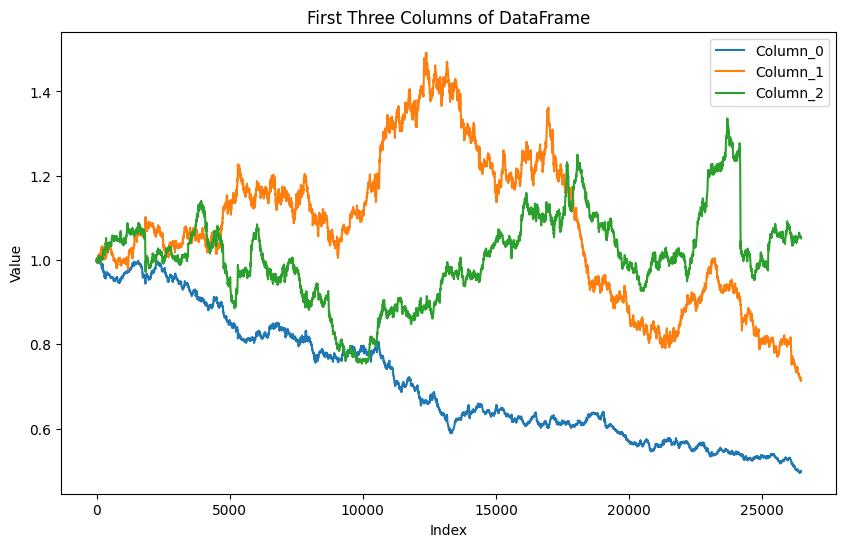

In [3]:
plt.figure(figsize=(10, 6))
plt.plot(df['Column_0'], label='Column_0')
plt.plot(df['Column_1'], label='Column_1')
plt.plot(df['Column_2'], label='Column_2')

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('First Three Columns of DataFrame')
plt.legend()

plt.show()

<div style="background-color:purple; color:white; padding:10px;">
    <h1><a name="CLUSTERING_USING_ABSOLUTE_CORRELATION"></a>CLUSTERING USING ABSOLUTE CORRELATION</h1>
</div>

In the bar graph that follows, you'll notice that varying numbers of stocks are allocated to distinct cluster labels. The overarching objective of this exercise is to exclusively group stocks that exhibit high correlations with one another. To achieve this aim, the 'centroid' method has been employed for linkage. The parameter 'correlation_threshold' is flexible and can be adjusted to align with your specific requirements or analytical objectives.

In [4]:
# Calculate the correlation matrix for the time series
correlation_matrix = df.corr()
correlation_matrix_abs = df.corr().abs()

# Perform hierarchical clustering using the 'average' linkage method
linkage_matrix = sch.linkage(correlation_matrix_abs, method='centroid')

# Define a threshold for clustering (adjust as needed)
correlation_threshold = 2.5

# Get cluster labels based on the threshold
cluster_labels = sch.fcluster(linkage_matrix, t=correlation_threshold, criterion='distance')

# Create a new DataFrame with cluster labels
clustered_df = pd.DataFrame({'Cluster_Label': cluster_labels})

# Display the new DataFrame with cluster labels
print(clustered_df)

     Cluster_Label
0               10
1                1
2                1
3               10
4               10
..             ...
195             10
196             10
197             12
198             10
199              2

[200 rows x 1 columns]


In [5]:
correlation_matrix.to_csv('/kaggle/working/correlation_matrix.csv', index=False)

In [6]:
var = df.var()
var.to_csv('/kaggle/working/var.csv', index=False)

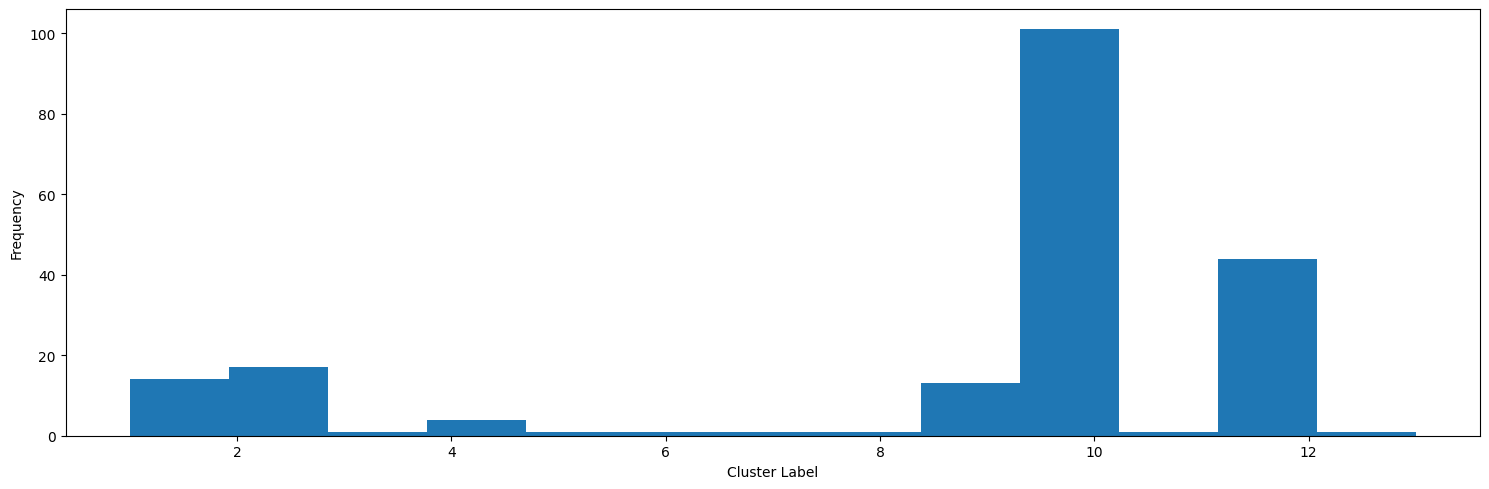

In [7]:
num_thresholds = 1
fig, axes = plt.subplots(1, num_thresholds, figsize=(15, 5))  # Adjust figsize as needed
axes.hist(clustered_df['Cluster_Label'], bins=clustered_df['Cluster_Label'].max())
axes.set_xlabel("Cluster Label")
axes.set_ylabel("Frequency")
# Adjust spacing between subplots
plt.tight_layout()

# Show the subplots
plt.show()

<div style="background-color:purple; color:white; padding:10px;">
    <h1> <a name="SUB-CLUSTER_LABELING"></a>SUB-CLUSTER LABELING</h1>
</div>

In the existing clustering framework, stocks exhibiting both negative and positive correlations are grouped under the same label. To refine this categorization and achieve the desired number_letter format for labeling, I employ a secondary layer of clustering within these initial clusters. Concluding this section, you'll find a data frame, referred to as 'clustered_df,' that features a 'Combined_Label' attribute formatted as per the stipulated guidelines.

In [8]:
# Define the number of sub-clusters within each cluster label
num_sub_clusters = 2

# Create a DataFrame to store sub-cluster labels
sub_clustered_df = pd.DataFrame()

# Iterate through each unique cluster label in 'clustered_df'
unique_cluster_labels = clustered_df['Cluster_Label'].unique()
clustered_df['Sub_Cluster_Label'] = np.nan
correlation_matrix = df.corr()

for cluster_label in unique_cluster_labels:
    # Filter the rows and columns of 'correlation_matrix' for the current cluster
    cluster_indices = clustered_df.index[clustered_df['Cluster_Label'] == cluster_label]
    sub_correlation_matrix = correlation_matrix.iloc[cluster_indices, cluster_indices]
    
    # Check if the sub_correlation_matrix is empty
    if sub_correlation_matrix.shape == (1, 1):
        print(f"Skipping 1x1 matrix for cluster label: {cluster_label}")
        # You could decide to assign a default sub_cluster_label for this case if needed
        clustered_df.loc[clustered_df.index.isin(cluster_indices), 'Sub_Cluster_Label'] = 1
        continue
    # Perform hierarchical clustering on the filtered correlation matrix
    linkage_matrix = sch.linkage(sub_correlation_matrix, method='average')

    # Get sub-cluster labels based on the desired number of sub-clusters
    sub_cluster_labels = sch.fcluster(linkage_matrix, t=num_sub_clusters, criterion='maxclust')
    
    clustered_df.loc[clustered_df.index.isin(cluster_indices), 'Sub_Cluster_Label'] = sub_cluster_labels

clustered_df['Sub_Cluster_Label'] = clustered_df['Sub_Cluster_Label'].astype(int)
clustered_df

Skipping 1x1 matrix for cluster label: 8
Skipping 1x1 matrix for cluster label: 13
Skipping 1x1 matrix for cluster label: 11
Skipping 1x1 matrix for cluster label: 6
Skipping 1x1 matrix for cluster label: 7
Skipping 1x1 matrix for cluster label: 3
Skipping 1x1 matrix for cluster label: 5


,Cluster_Label,Sub_Cluster_Label
0,10,2
1,1,2
2,1,1
3,10,2
4,10,2
...,...,...
195,10,2
196,10,1
197,12,2
198,10,2


In [9]:
# Define the list of index labels you want to access
index_labels = [5, 12, 55, 183, 170, 135, 172, 6, 47, 69, 98, 22, 142, 162, 99, 61, 173, 93, 101, 176]

# Access the rows with the specified index labels
selected_rows = clustered_df.loc[index_labels]
print(selected_rows)


     Cluster_Label  Sub_Cluster_Label
5                2                  2
12              10                  2
55               2                  1
183              2                  2
170              2                  1
135              2                  2
172              2                  2
6                2                  2
47               8                  1
69               2                  1
98               2                  2
22               4                  1
142              5                  1
162              2                  1
99               2                  1
61               9                  2
173              2                  2
93               7                  1
101              4                  1
176              1                  2


In [10]:
# Function to create the combined label
def create_combined_label(row):
    cluster = row['Cluster_Label']
    sub_cluster = row['Sub_Cluster_Label']
    letter = 'a' if sub_cluster == 1 else 'b'
    return f"{cluster}_{letter}"

# Apply the function to create the 'Combined_Label' column
clustered_df['Combined_Label'] = clustered_df.apply(create_combined_label, axis=1)
clustered_df.to_csv('/kaggle/working/clustered_df.csv', index=False)
clustered_df

,Cluster_Label,Sub_Cluster_Label,Combined_Label
0,10,2,10_b
1,1,2,1_b
2,1,1,1_a
3,10,2,10_b
4,10,2,10_b
...,...,...,...
195,10,2,10_b
196,10,1,10_a
197,12,2,12_b
198,10,2,10_b


In [11]:
clustered_df.iloc[171]

Cluster_Label          10
Sub_Cluster_Label       2
Combined_Label       10_b
Name: 171, dtype: object

<div style="background-color:purple; color:white; padding:10px;">
    <h1> <a name="VALIDATION"></a>VALIDATION</h1>
</div>

In the following section, I aim to evaluate the efficacy of the clustering methodology implemented in the preceding chapter. This validation exercise serves as a diagnostic tool, enabling us to recalibrate our approach if the current clustering does not fulfill its intended objectives. Specifically, we may consider adjusting the number of clusters or even revising the clustering algorithm itself.

<div style="background-color:gray; color:white; padding:10px;">
    <h3> <a name="ABSOLUTE_CLUSTERS"></a>ABSOLUTE CLUSTERS</h3>
</div>

In this segment, we examine the correlation among stocks residing within identically labeled (absolute) clusters, distinguished by their absolute values. Clusters marked with a value of '1' contain only a single stock, inherently demonstrating perfect correlation. It is anticipated that higher correlation values will be observed within each cluster. Importantly, as the number of stocks within a given cluster diminishes, the correlation is likely to rise, highlighting an intrinsic trade-off in our clustering strategy.

/tmp/ipykernel_20/1609732997.py:11: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(pairwise_distances_matrix, method='average')


    Intra_Cluster_Correlation
1                    0.646837
2                    0.323672
3                    1.000000
4                    0.704093
5                    1.000000
6                    1.000000
7                    1.000000
8                    1.000000
9                    0.596512
10                   0.848619
11                   1.000000
12                   0.736765
13                   1.000000


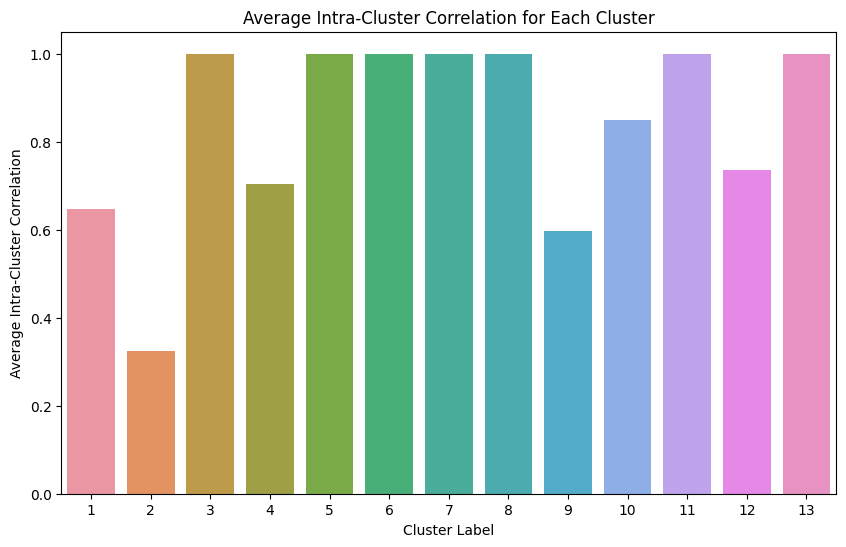

In [12]:
# Calculate the correlation matrix for the time series
correlation_matrix_abs = df.corr().abs()

# Calculate the pairwise Euclidean distances between time series
pairwise_distances_matrix = np.sqrt(2 * (1 - correlation_matrix_abs))

# Ensure the pairwise distances matrix is symmetric
pairwise_distances_matrix = 0.5 * (pairwise_distances_matrix + pairwise_distances_matrix.T)

# Calculate the linkage matrix for hierarchical clustering
linkage_matrix = linkage(pairwise_distances_matrix, method='average')

# Get cluster labels from the hierarchical clustering
n_clusters = len(clustered_df['Cluster_Label'].unique())

# Initialize a dictionary to store intra-cluster correlations
intra_cluster_correlations = {cluster_label: [] for cluster_label in range(1, n_clusters + 1)}

# Iterate through each time series and calculate intra-cluster correlations
for cluster_label in range(1, n_clusters + 1):
    cluster_indices = clustered_df.index[clustered_df['Cluster_Label'] == cluster_label]
    cluster_corr_matrix = correlation_matrix_abs.iloc[cluster_indices, cluster_indices]
    avg_corr = cluster_corr_matrix.mean().mean()
    intra_cluster_correlations[cluster_label].append(avg_corr)

# Create a DataFrame to store the intra-cluster correlations
intra_cluster_corr_df = pd.DataFrame.from_dict(intra_cluster_correlations, orient='index', columns=['Intra_Cluster_Correlation'])

# Display the intra-cluster correlation DataFrame 
print(intra_cluster_corr_df)

# Visualize the intra-cluster correlation using a bar plot 
plt.figure(figsize=(10, 6))
sns.barplot(x=intra_cluster_corr_df.index, y='Intra_Cluster_Correlation', data=intra_cluster_corr_df)
plt.xlabel('Cluster Label')
plt.ylabel('Average Intra-Cluster Correlation')
plt.title('Average Intra-Cluster Correlation for Each Cluster')
plt.show()

<div style="background-color:gray; color:white; padding:10px;">
    <h3> <a name="THE_FINAL_CLUSTERS"></a>THE FINAL CLUSTERS</h3>
</div>

In this section, we delve into the correlation dynamics among stocks grouped within the same 'final' clusters. Those clusters denoted by a value of '1' consist of a solitary stock, and by definition, exhibit a correlation coefficient of one. It is generally anticipated that a high degree of correlation will be present within each cluster. As stated before, as the number of stocks within a given cluster diminishes, the correlation is likely to rise, highlighting an intrinsic trade-off in our clustering strategy.

/tmp/ipykernel_20/42709199.py:11: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(pairwise_distances_matrix, method='average')


   Cluster_Label  Intra_Cluster_Correlation
0           10_b                   0.871767
1            1_b                   0.643837
2            1_a                   0.705590
3            2_b                   0.212053
4           12_b                   0.752014
5           10_a                   0.791065
6            4_a                   0.723039
7           12_a                   0.722029
8            8_a                   1.000000
9            2_a                   0.400252
10          13_a                   1.000000
11           9_b                   0.637447
12           4_b                   1.000000
13          11_a                   1.000000
14           9_a                   0.664995
15           6_a                   1.000000
16           7_a                   1.000000
17           3_a                   1.000000
18           5_a                   1.000000


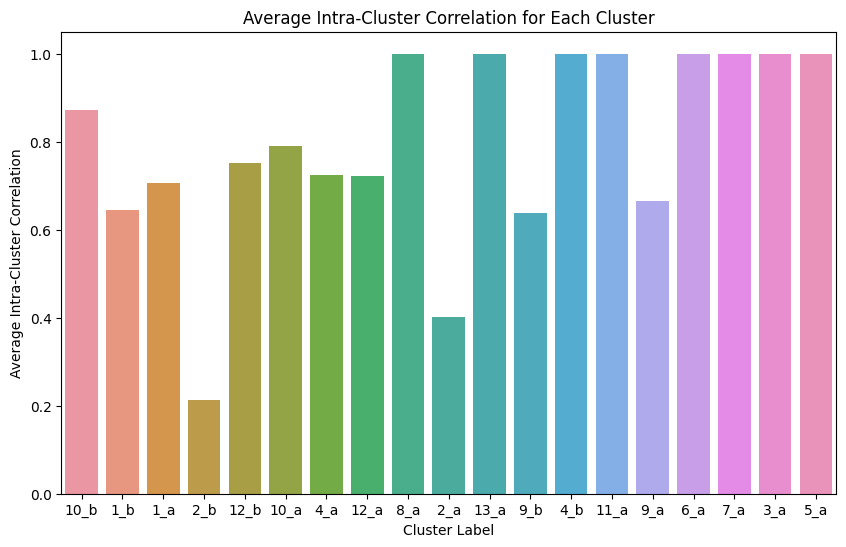

In [13]:
# Calculate the correlation matrix for the time series
correlation_matrix = df.corr()

# Calculate the pairwise Euclidean distances between time series
pairwise_distances_matrix = np.sqrt(2 * (1 - correlation_matrix))

# Ensure the pairwise distances matrix is symmetric
pairwise_distances_matrix = 0.5 * (pairwise_distances_matrix + pairwise_distances_matrix.T)

# Calculate the linkage matrix for hierarchical clustering
linkage_matrix = linkage(pairwise_distances_matrix, method='average')

# Get cluster labels from the hierarchical clustering
n_clusters = len(clustered_df['Combined_Label'].unique())
intra_cluster_correlations = {}


for combined_label in clustered_df['Combined_Label'].unique():
    cluster_indices = clustered_df.index[clustered_df['Combined_Label'] == combined_label].tolist()
    cluster_corr_matrix = correlation_matrix.iloc[cluster_indices, cluster_indices]
    avg_corr = cluster_corr_matrix.mean().mean()
    intra_cluster_correlations[combined_label] = avg_corr

# Create a DataFrame to store the intra-cluster correlations
intra_cluster_corr_df = pd.DataFrame(list(intra_cluster_correlations.items()), columns=['Cluster_Label', 'Intra_Cluster_Correlation'])

# Display the intra-cluster correlation DataFrame
print(intra_cluster_corr_df)

# Visualize the intra-cluster correlation using a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=intra_cluster_corr_df.Cluster_Label, y='Intra_Cluster_Correlation', data=intra_cluster_corr_df)
plt.xlabel('Cluster Label')
plt.ylabel('Average Intra-Cluster Correlation')
plt.title('Average Intra-Cluster Correlation for Each Cluster')
plt.show()

<div style="background-color:gray; color:white; padding:10px;">
    <h3> <a name="INTER-CLUSTER_CORRELATION"></a>INTER-CLUSTER CORRELATION</h3>
</div>

This part of the validation process is really interesting because it helps us understand how different groups, or clusters, relate to each other. I created two clusters, named 'a' and 'b,' to show how some stocks negatively affect each other. The next graph will show us how well this idea works and if it needs any changes.

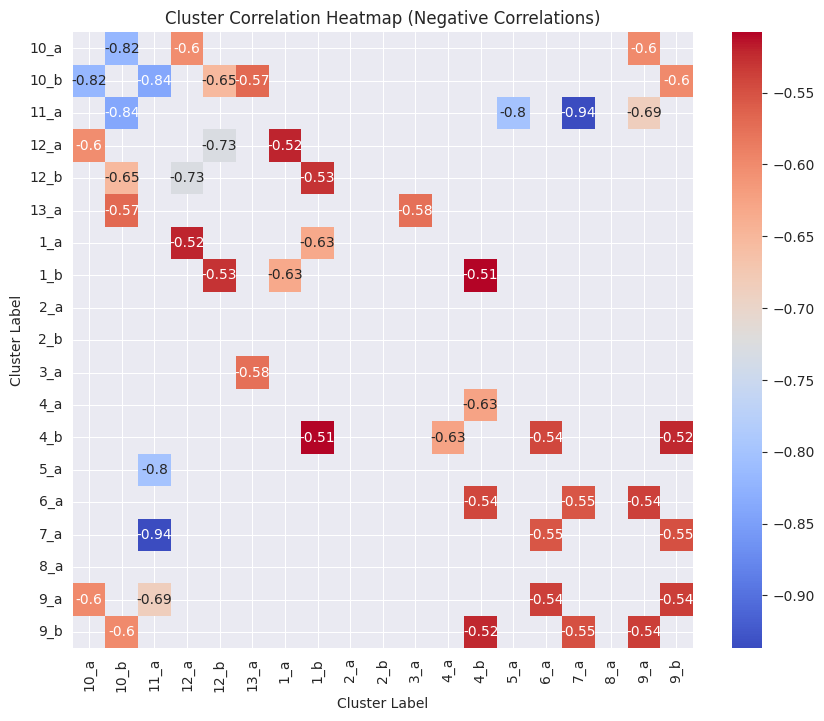

In [14]:
correlation_matrix = df.corr()
# Calculate the correlation matrix between clusters
cluster_correlation_matrix = np.zeros((len(np.unique(clustered_df.Combined_Label)), len(np.unique(clustered_df.Combined_Label))))

for i, cluster_i in enumerate(np.unique(clustered_df.Combined_Label)):
    for j, cluster_j in enumerate(np.unique(clustered_df.Combined_Label)):
        # Select time series corresponding to each cluster
        cluster_i_indices = clustered_df.index[clustered_df['Combined_Label'] == cluster_i]
        cluster_j_indices = clustered_df.index[clustered_df['Combined_Label'] == cluster_j]

        # Calculate the correlation between the mean of each cluster
        correlation = correlation_matrix.iloc[cluster_i_indices, cluster_j_indices].mean().mean()
        cluster_correlation_matrix[i, j] = correlation

# Create a DataFrame to store the cluster correlation matrix
cluster_corr_df = pd.DataFrame(cluster_correlation_matrix, columns=np.unique(clustered_df.Combined_Label), index=np.unique(clustered_df.Combined_Label))

# Set a threshold to identify strong negative correlations
negative_corr_threshold = -0.5  # Adjust as needed

# Create a mask to select clusters with strong negative correlations
mask = (cluster_corr_df < negative_corr_threshold) & (cluster_corr_df != 1)
# Setting rc parameters in seaborn for plots and graphs:
sns.set(
    {
     "grid.linewidth": 0.75,
     "grid.linestyle": "--"}
)

# Create a heatmap to visualize negative correlations 
plt.figure(figsize=(10, 8))
sns.heatmap(cluster_corr_df, annot=True, cmap='coolwarm',mask=~mask)
plt.xlabel('Cluster Label')
plt.ylabel('Cluster Label')
plt.title('Cluster Correlation Heatmap (Negative Correlations)')
plt.show()

<div style="background-color:purple; color:white; padding:10px;">
    <h1> <a name="CONCLUSION"></a>CONCLUSION</h1>
</div>

I provided some clusters which represents positive and negative correlation between stocks. This information can be used as a feature to improve our time series forecasting. The number of clusters and clustering methods can be changed for different models/purposes.

The proposed clusters have number_letter format. If two stocks are within the same number_letter cluster; that means they are highly positively correlated. On the other hand, if two stocks are within the same number but different letter clusters; that means they are higly negatively correlated. Therefore, for example if you want to predict the future movements of a stock belonging to 9_a cluster; the movement of other stocks that are in 9_a and 9_b clusters can provide significant information.

Thanks for reading.